# 加载

In [1]:
import plotly.graph_objects as go
import datetime
from datetime import datetime
import random
import calendar
import time
import seaborn as sns
import tensorflow as tf
from sklearn import svm
from subprocess import call
from scipy import signal
from sklearn import tree
from sklearn import neighbors
import sklearn
from matplotlib.lines import Line2D
import statsmodels.tsa.stattools as ts
import matplotlib.ticker as mtick
import matplotlib.collections as collections
from numpy import linalg
from IPython.display import Image
import os
import graphviz
import sys
import csv
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
import numpy as np
import warnings
import xgboost as xgb
from sklearn.tree import export_graphviz
from sklearn import datasets
warnings.filterwarnings("ignore")
import math
import operator
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm
from sklearn import preprocessing
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import stats
from copy import deepcopy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_validate
from WindPy import w
from numpy import exp, array, random, dot
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# 函数

## 神经网络

In [2]:
#激活函数及坡度
def sig(x):
    return 1 / (1 + exp(-x))

def sig_drv(x):
    return x * (1-x)

#生成初始神经网络
def gen_layer(x,y,nnum):
    res = [2 * random.random((len(x[0]), nnum[0])) - 1]
    if len(nnum) > 1:
        for i in range(1,len(nnum)):
            res.append(2 * random.random((nnum[i-1], nnum[i])) - 1)
    res.append(2 * random.random((nnum[-1], len(y[0]))) - 1)
    return res

#输入结果
def calc(x, nn):
    res = []
    for i in range(len(nn)):
        if i == 0:
            res.append(sig(dot(x, nn[i])))
        else:
            res.append(sig(dot(res[-1], nn[i])))
    return res

#训练
def correct(x, y, nnum, time,prt):
    layer = gen_layer(x,y,nnum)
    for j in range(time):
        res = calc(x, layer)
        det = []
        err = []
        adj = []
        for i in range(len(layer)-1,-1,-1):
            if i == len(layer)-1:
                err.append(y - res[-1])
                det.append(err[0] * sig_drv(res[-1]))
            else:
                err.append(det[-1].dot((layer[i+1]).T))
                det.append(err[-1] * sig_drv(res[i]))
        
        det = det[::-1]
        for i in range(len(det)):
            if i == 0:
                adj.append((x.T).dot(det[i]))
            else:
                adj.append((res[i-1].T).dot(det[i]))        
        for i in range(len(layer)):
            layer[i] += adj[i]
    if prt:
        print('神经层',layer)
    return layer

## @@@@@@@@@@@多组数据加工

In [3]:
#l选取数据时长
def data_pro(data,l):
    df = []
    for i in range(l-1,len(date)):
        temp = []
        for j in range(len(data)):
            i = int(i)
            j = int(j)
            
            #选取第j组数据
            il = data[j][i-l+1:i+1]
            
            #价格与移动平均线的关系 
            temp.append(-(-1) ** (data[j][i] >= np.mean(il)))
            temp.append(-(-1) ** (data[j][i] >= np.mean(il[3:])))
            temp.append(-(-1) ** (data[j][i] >= np.mean(il[6:])))
            temp.append(-(-1) ** (data[j][i] >= np.mean(il[9:])))
            temp.append(-(-1) ** (data[j][i] >= data[j][i-1]))
            
            
            #ROC 
            temp.append(il[-1]/(il[-2]+10e-4)-1)
            temp.append(il[-1]/(il[-4]+10e-4)-1)
            temp.append(il[-1]/(il[-7]+10e-4)-1)
            temp.append(il[-1]/(il[-10]+10e-4)-1)
            temp.append(il[-1]/(il[0]+10e-4)-1)
    
        df.append(temp)
    return df

## 预测结果评估

In [4]:
#准确度计算
def acc(res,ans):
    if len(res) != len(ans):
        return('准确度数据长度不同')
    else:
        return round(sum(np.array(res) == np.array(ans))/ len(res),2)

        

#收益率计算
def profit(data, ud):
    if len(data) != len(ud):
        return('收益率数据长度不同')
    money = 1
    num = 0
    prt = 0   #显示买卖记录
    m2y = 1   #是否年化收益
    for i in range(len(data)):
        if ud[i] == 1 and num == 0:
            if prt:
                print('in', date[11:][i], 'money', money, 'num', num, 'price', data[i])
 
            num = money/(data[i]+10e-6)
            money = 0
        if ud[i] == -1 and money == 0 and data[i] != 0:
            if prt:
                print('out', date[11:][i], 'money', money, 'num', num, 'price', data[i])
            money = num * data[i]
            num = 0
    if prt:
        print('结果',money+num*data[-1])
    if m2y:
        return (money+num*data[-1]) ** (1/len(data)*12)-1
    return money+num*data[-1]-1

#错误区间占比
def wrong_div(dat, ud):
    if len(dat) != len(ud):
        return('错误区间数据长度不同')
    
    c_div = 1
    c_wrong = 0
    l_wrong = 1
    l_all = 0
    dirc = ud[0]
    last = dat[0]
    for i in range(1,len(dat)):
        l_wrong += 1
        if ud[i] == 0:
            return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(dat))
        if ud[i] != dirc:
            c_div += 1
            if -(-1)**(dat[i] > last) != dirc:
                c_wrong += 1
                l_all += l_wrong
            l_wrong = 1
            last = dat[i]
            dirc = ud[i]
            
    return str(c_wrong)+'/'+str(c_div), str(l_all)+'/'+str(len(data))

#复杂度计算
def cpx(x):
    res = 1
    dirc = x[0]
    for i in range(len(x)):
        if x[i] != dirc:
            res += 1
            dirc = x[i]
    return res/len(x)

## 趋势划分

In [5]:
def und(dat, l1, l2):
    i = 0
    res = [0] * len(dat)

    while i < len(dat)-1:
        if i + l1 >= len(dat) - 1 - l2:
            for j in range(i, len(dat)-l2):
                res[j] = res[i]
            break
        cur = dat[i]
        next_id = min([(dat[i+1:]).index(max(dat[i+1+l1:i+1+l2])), (dat[i+1:]).index(min(dat[i+1+l1:i+1+l2]))]) +i+1
        res[i:next_id+1] = [- (-1) ** (dat[next_id] > dat[i])] * (next_id + 1 - i)
        i = next_id
    return res

In [6]:
def und_pro(dat, l1, l2):
    i = 0
    see = []
    res = [0] * len(dat)

    while i < len(dat)-1:
        if i + l1 >= len(dat) - 1 - l2:
            for j in range(i, len(dat)-l2):
                res[j] = res[i]
            break
        cur = dat[i]
        next_id = min([(dat[i+1:]).index(max(dat[i+1+l1:i+1+l2])), (dat[i+1:]).index(min(dat[i+1+l1:i+1+l2]))]) +i+1
        res[i:next_id+1] = [- (-1) ** (dat[next_id] > dat[i])] * (next_id + 1 - i)
        i = next_id
        temp = deepcopy(res)
        see.append(temp)
    return see

## 移动平均，大小比较与时间处理

### 滤波生成

In [7]:
def hp(data):
    cycle, trend = sm.tsa.filters.hpfilter(data, lamb=129600)
    return trend

### 拐点识别

In [8]:
def tar(ud):
    res = [0]
    cur = ud[0]
    for i in range(1,len(ud)):
        if ud[i] != cur and ud[i] != 0:
            res.append(ud[i])
            cur = ud[i]
        else:
            res.append(0)
    return res

### 去春节性

In [9]:
#通过平均去春节影响
def spring(data, date):
    res = []
    for i in range(len(data)):
        if date[i].month == 1 and i < len(date)-1:
            temp = deepcopy(data[i]+data[i+1])/2
            res.append(temp)
            res.append(temp)
        elif date[i].month == 2:
            continue
        else:
            res.append(data[i])
    return res

### 波峰波谷

In [10]:
#波峰挑选
def peak(data):
    res = [0]
    for i in range(1, len(data)-1):
        if data[i-1] < data[i] > data[i+1]:
            res.append(data[i])
        else:
            res.append(0)
    res.append(0)
    return res

#波谷挑选
def bot(data):
    res = [0]
    for i in range(1, len(data)-1):
        if data[i-1] > data[i] < data[i+1]:
            res.append(data[i])
        else:
            res.append(0)
    res.append(0)
    return res

### 清理重复月份，需要月数据！！！

In [11]:
#清理重复的月份
def date_clean(date,data):
    date_res = [date[0]]
    data_res = [[i[0]] for i in data]
    
    last = date[0]
    
    for i in range(len(date[1:])):
        cur = date[i]
        if cur.month != last.month:
            date_res.append(cur)
            for j in range(len(data_res)):
                data_res[j].append(data[j][i])
        last = date[i]

    return date_res, data_res

### 移动平均相关

In [12]:
#data l_ma长度的移动平均线
def ma(data, l_ma):
    res = []
    for i in range(l_ma-1,len(data)):
        res.append(np.mean(data[i-l_ma+1:i+1]))
    return res

#ROCSMA变化率移动平均
def rocsma(d1,i1,l_roc,l_sma):
    res = 0
    for x in range(l_sma):
        res += (d1[i1-x]/d1[i1-x-l_roc]-1)/l_sma
    return res

#KST公式
def kst(d2,roc_l1,roc_l2,roc_l3,roc_l4,sma_l1,sma_l2,sma_l3,sma_l4):
    res = []
    for i in range(roc_l4+sma_l4, len(d2)):
        rocma1 = rocsma(d2,i,roc_l1,sma_l1)
        rocma2 = rocsma(d2,i,roc_l2,sma_l2)
        rocma3 = rocsma(d2,i,roc_l3,sma_l3)
        rocma4 = rocsma(d2,i,roc_l4,sma_l4)
        res.append(rocma1 * 1 + rocma2 * 2 + rocma3 * 3 + rocma4 * 4)
    return res

#加权移动平均
def ewma(data,l):
    aw = sum([i for i in range(1,13)])
    res = []
    for i in range(l-1, len(data)):
        temp = 0
        for j in range(l):
            temp += data[i-j]*(12-j)/aw
        res.append(temp)
    return res

### 序列大小判断

In [13]:
def slope(data):
    res = [0]
    for i in range(1,len(data)):
        res.append(-(-1) ** (data[i]>data[i-1]))
    res[0] = res[1]
    return res

### 获取下个月末的日期

In [14]:
#获取下个月末
def next_month(date):
    if date.month == 12:
        res = date.replace(year = date.year + 1, month = 1, day = calendar.monthrange(int(date.year+1), 1)[1])
    else:
        res = date.replace(month = date.month + 1, day = calendar.monthrange(int(date.year), date.month + 1)[1])
    return res

### 相对强度

In [15]:
#相对强度
def rele_str(data, i1, i2):
    return (np.array(data[i1])/np.mean(data[i1])) / (np.array(data[i2])/np.mean(data[i2]))

### 日期变为天数

In [16]:
def date2num(date):
    d8 = []
    for i in range(len(date)):
        d8.append(int((date[i] - date[0]).days))
    return d8

### 找年份

In [17]:
def find1y(date):
    last = date[0]
    for i in range(len(date)):
        cur = date[i]
        if cur.year != last.year:
            return i
        last = date[i]

### 其他

In [18]:
#检查长度
def clen(d1,d2):
    print(len(d1),len(d2))

#大小对比
def comp(d1,d2):
    if len(d1) != len(d2):
        return '长度不同'
    res = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    return res

#平均值规范化
def std(data):
    res = [1]
    for i in range(1, len(data)):
        res.append((data[i] - np.mean(data[:i]))/np.mean(data[:i]))
    return res

#相关性
def calc_corr(a, b):
    a_avg = sum(a)/len(a)
    b_avg = sum(b)/len(b)
 
    cov_ab = sum([(x - a_avg)*(y - b_avg) for x,y in zip(a, b)])
 
    sq = math.sqrt(sum([(x - a_avg)**2 for x in a])*sum([(x - b_avg)**2 for x in b]))

    corr_factor = cov_ab/sq
 
    return corr_factor


#???????????????????????
#交叉变换趋势
def cross(d1,d2,cd):
    comp = [-(-1) ** (d1[i] > d2[i]) for i in range(len(d1))]
    res = [-comp[0]]
    c = 0
    
    for i in range(1,len(comp)):
        if comp[i] * comp[i-1] == -1 and c == 0:
            sl1 = -(-1)**(d1[i]>d1[i-1])
            sl2 = -(-1)**(d2[i]>d2[i-1])
            res.append(sl1*sl2)
            c += cd
        else:
            res.append(res[-1])
            c = max(0,c-1)
    return res

#平滑折线
def smooth(data):
    for i in range(len(data)-4):
        if data[i] * data[i+2] == 1 and data[i] * data[i+1] == -1:
            data[i+1] = data[i]
        elif data[i] * data[i+3] == 1 and all(data[i+1:i+3]) != data[i]:
            for j in range(2):
                data[i+j+1] = data[i]
        elif data[i] * data[i+4] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(3):
                data[i+j+1] = data[i]
    return data

def smooth2(data):
    for i in range(len(data)-5):
        if data[i] * data[i+5] == 1 and all(data[i+1:i+4]) != data[i]:
            for j in range(4):
                data[i+j+1] = data[i]
    return data

def l2n0(data):
    res = []
    for i in range(len(data)):
        if data[::-1][i] != 0:
            res.append(data[::-1][i])
        if len(res) == 2:
            break
    return res[0]/res[1]-1

## 训练验证集划分

In [19]:
#训练与验证集
def trvd(x, y, ratio):
    train_x = x[:int(len(x)*ratio)]
    valid_x = x[int(len(x)*ratio):]
    train_y = y[:int(len(x)*ratio)]
    valid_y = y[int(len(x)*ratio):]
    
    print(len(train_x), len(valid_x), len(train_y), len(valid_y))
    return train_x, valid_x, train_y, valid_y

## 画图

In [20]:
def supa_plot(d,ud,ii,m_name):
    plt.rcParams['font.family']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title(list(d)[ii]+m_name+'预测',fontproperties='SimHei', size = 20)
    ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(d)[ii])
    
    ll = len(data) - len(ud)
    
    plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
    plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),52)])
    plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

    collection = collections.BrokenBarHCollection.span_where(
    d8[ll:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud) == 1, facecolor='red', alpha=.15, label = '上行')
    ax.add_collection(collection)

    collection = collections.BrokenBarHCollection.span_where(
    d8[ll:], ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(ud) == -1, facecolor='green', alpha=.15, label = '下行')
    ax.add_collection(collection)

    colors = ['black', 'red', 'green']
    new_legends = ["-"] * len(colors)
    markers = ['-'] * len(colors)
    
    _, labels = ax.get_legend_handles_labels()
    
    duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
    ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)
    
    plt.show()

def dupe_legend(label, color):
    line = Line2D([0], [0], linestyle='none', mfc= 'white',
                mec=color, marker=r'$\mathregular{{{}}}$'.format(label))
    return line

## 时间序列相关

In [21]:
#时间序列模型预测
def ts_predict(data, date, n_steps):
    
    f, err95, ci95 = best_mdl.forecast(steps=n_steps)
    idx = [date[-1]]
    for i in range(n_steps-1):
        idx.append(next_month(idx[-1]))
    fc_all = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
    return fc_all['forecast'][1]

def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.ewma(timeSeries, span=size)

    timeSeries.plot(color='blue', label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()
    
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):#定义局部样式
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)#自相关系数ACF图
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)#偏相关系数PACF图
        sm.qqplot(y, line='s', ax=qq_ax)#QQ图检验是否是正态分布
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

# 读取数据

In [22]:
d_w = (pd.read_excel('df_w.xls',index_col=0)).fillna(0)
d_w

,南华综合指数:周,上证综合指数:周,中债国开债到期收益率:10年:周
指标名称,,,
2004-07-03,1009.7499,1441.1900,4.4712
2004-07-10,983.1494,1430.6540,4.2881
2004-07-17,976.6077,1456.1300,4.2210
2004-07-24,962.8449,1407.3960,4.2776
2004-07-31,965.7056,1386.2020,4.2120
...,...,...,...
2020-08-29,1508.9100,3403.8066,3.6186
2020-09-05,1508.4000,3355.3666,3.6909
2020-09-12,1459.4900,3260.3461,3.6811


In [23]:
d_m = (pd.read_excel('df_m.xls',index_col=0)).fillna(0)
d_m

,南华综合指数:月,上证综合指数:月,中债国开债到期收益率:10年:月
指标名称,,,
2004-07-31,965.7056,1386.2020,4.2120
2004-08-31,979.0981,1342.0620,4.1766
2004-09-30,996.9959,1396.7000,4.6839
2004-10-31,958.4566,1320.5360,4.5308
2004-11-30,979.0357,1340.7710,4.4737
...,...,...,...
2020-06-30,1418.8700,2984.6741,3.1000
2020-07-31,1478.5400,3310.0065,3.4777
2020-08-31,1523.5300,3395.6775,3.5835


In [24]:
d_om = (pd.read_excel('df_om.xls',index_col=0)).fillna(0)
d_om

,工业增加值:同比,M1:同比,M2:同比
指标名称,,,
1995-12-31,14.9,16.8,29.5
1996-01-31,16.9,11.4,25.9
1996-02-29,12.2,16.6,27.2
1996-03-31,12.2,13.8,28.3
1996-04-30,13.7,13.7,28.5
...,...,...,...
2020-04-30,3.9,5.5,11.1
2020-05-31,4.4,6.8,11.1
2020-06-30,4.8,6.5,11.1


# 证券市场的周数据处理&参数输入

In [25]:
date = d_w.index
data = [list(i) for i in array(d_w).T]
for i in range(len(data)):
    for j in range(len(data[i])):
        if data[i][j] == 0:
            data[i][j] = data[i][j-1]
            
#数据长度l
l = 12

#处理日期与数据
d8 = date2num(date)
df = data_pro(data,l)
L = int(len(df[0])/len(data))

#预测步长
step = 12

#结果统计
c = 0
name = []
r_name = []
#周趋势划分反应时间
w_fast = 12
w_slow = 48

#训练集样本基础大小
start = 300

#单组处理过的数据与涨跌趋势
for i in range(len(data)):
    exec('df'+str(i)+'=[j[L*i:L*(i+1)] for j in df]')
    exec('ud'+str(i)+'=und(list(data['+str(i)+']),'+ str(w_fast) +','+ str(w_slow) +')')
    
#总结
print('指数数量',len(data))
print('时间长度',len(date))
print('处理后数据范围',l-1,'~',len(df)+l-1)
print('趋势判断大概范围',0,'~',len(ud1[:ud1.index(0)]))

指数数量 3
时间长度 838
处理后数据范围 11 ~ 838
趋势判断大概范围 0 ~ 802


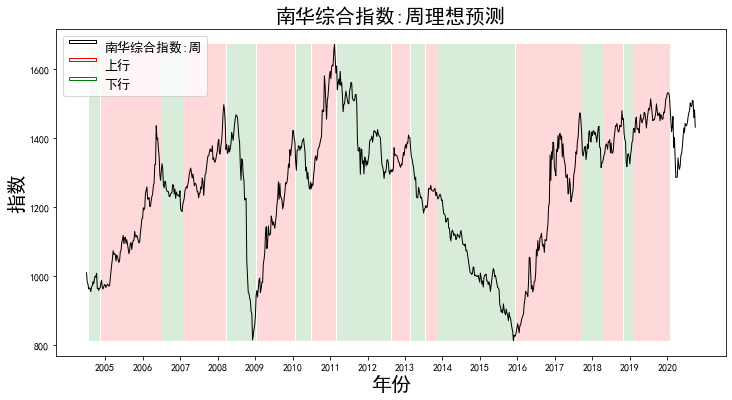

南华综合指数:周复杂度 2.27


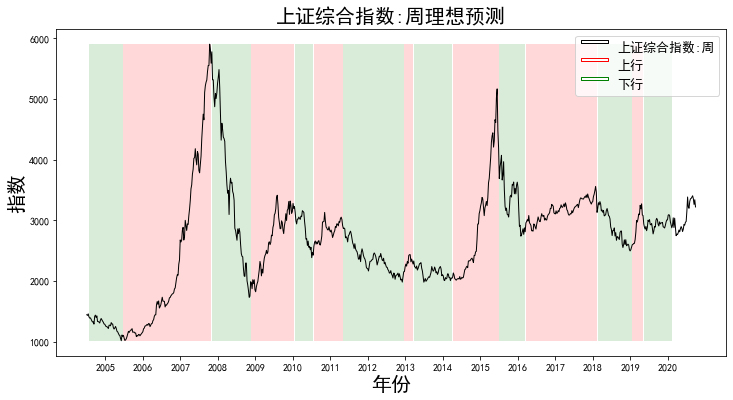

上证综合指数:周复杂度 1.91


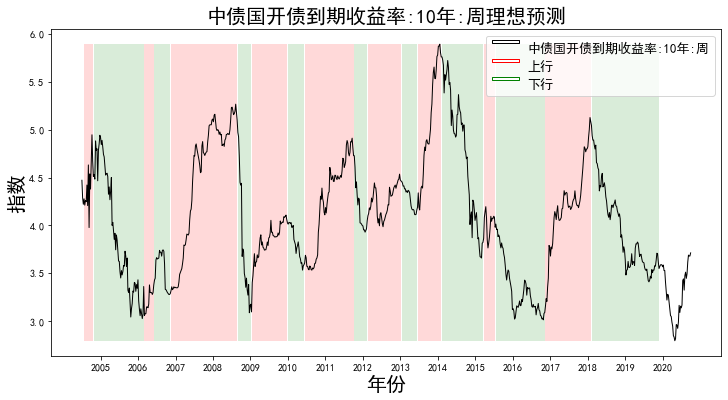

中债国开债到期收益率:10年:周复杂度 2.27


In [26]:
#理想趋势划分可视化

for ii in range(len(data)):
    supa_plot(d_w, eval('ud' + str(ii)), ii, '理想')
    exec('bc' + str(ii) + '= round( cpx(ud'+str(ii)+')  *100  ,  2    )  ')
    print(list(d_w)[ii]+'复杂度', eval('bc' + str(ii)))

# 趋势划分过程

ii = 2

plt.rcParams['font.family']=['SimHei']
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title(list(d_w)[ii]+'理想划分与极值判断的关系',fontproperties='SimHei', size = 20)
ax.plot(d8, data[ii], color='black', linewidth = 1, label = list(d_w)[ii])
ax.scatter(d8, data[ii], color='b', s = 0, label = '极值判断')

plt.xlabel(u'年份',fontproperties='SimHei',fontsize = 20)
plt.xticks([i for i in range(d8[find1y(date)],d8[-1],365)], [date[i].year for i in range(find1y(date),len(d8),12)])
plt.ylabel(u'指数',fontproperties='SimHei',fontsize = 20)

ax2 = ax.twinx()
ax2.scatter(d8[l-1:], [i[30-1] for i in df], color='b', s = 8)
plt.ylabel(u'极值',fontproperties='SimHei',fontsize = 20)

collection = collections.BrokenBarHCollection.span_where(
d8, ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(eval('ud'+str(ii))) == 1, facecolor='red', alpha=.15, label = '上行')
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
d8, ymin=min(data[ii]), ymax=max(data[ii]), where=np.array(eval('ud'+str(ii))) == -1, facecolor='green', alpha=.15, label = '下行')
ax.add_collection(collection)

colors = ['black', 'blue','red', 'green']
new_legends = ["-"] * len(colors)
markers = ['-'] * len(colors)

_, labels = ax.get_legend_handles_labels()

duplicates = [dupe_legend(leg, color) for leg, color in zip(new_legends, colors)]
ax.legend(duplicates, labels, numpoints=1, markerscale=5, fontsize=13)

exec('bc' + str(ii) + '= round( cpx(ud'+str(ii)+')  *100  ,  2    )  ')

plt.show()
print(list(d_w)[ii]+'趋势理想划分复杂度', eval('bc' + str(ii)),'%')

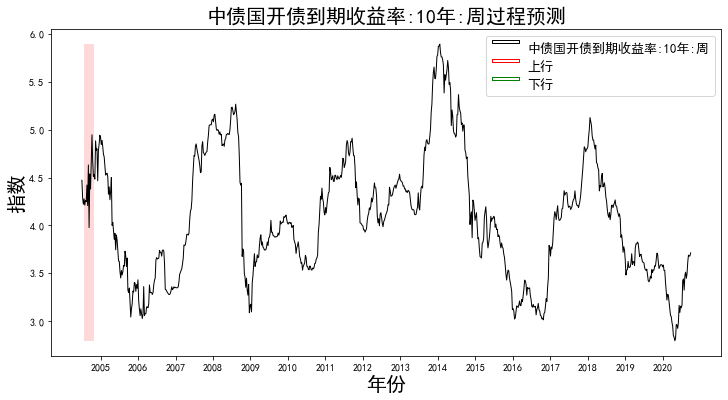

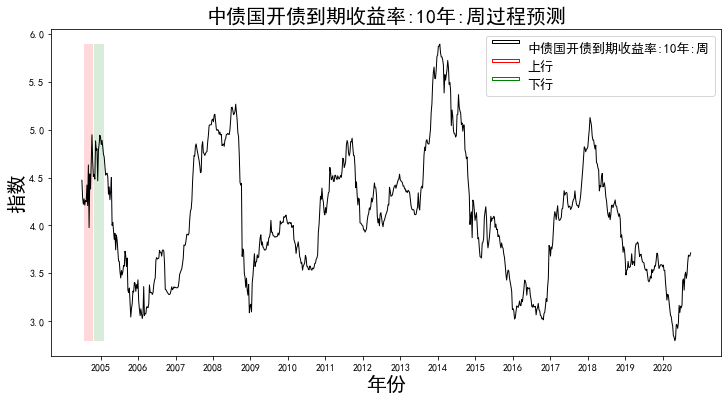

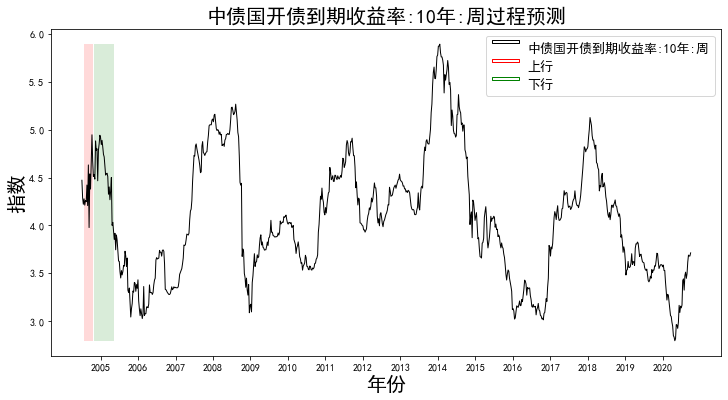

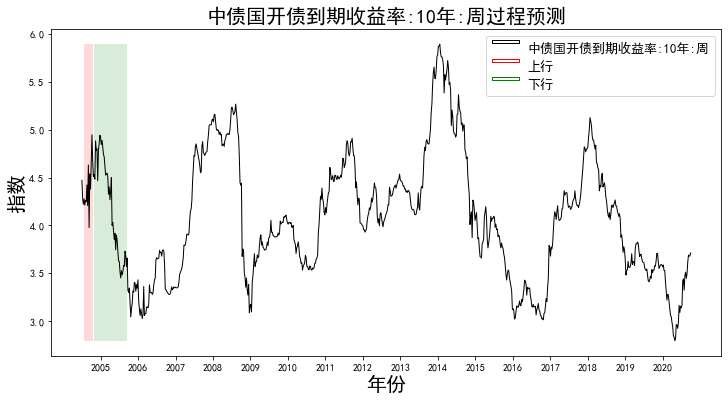

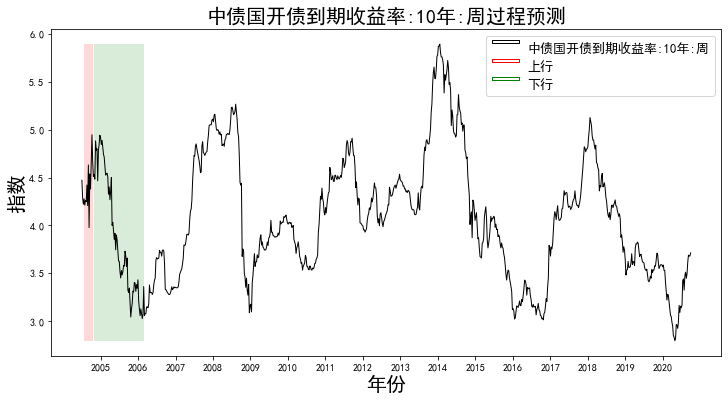

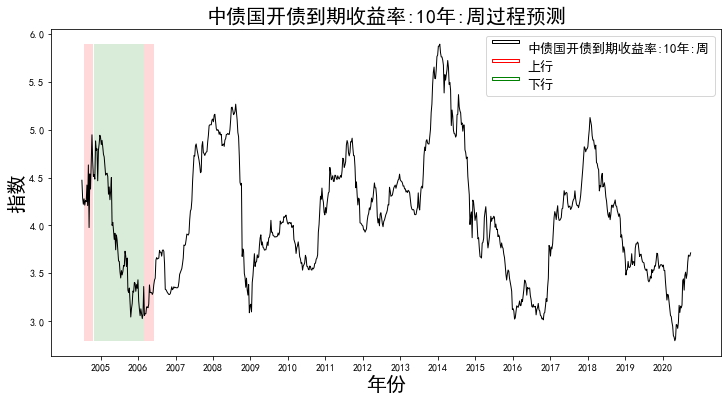

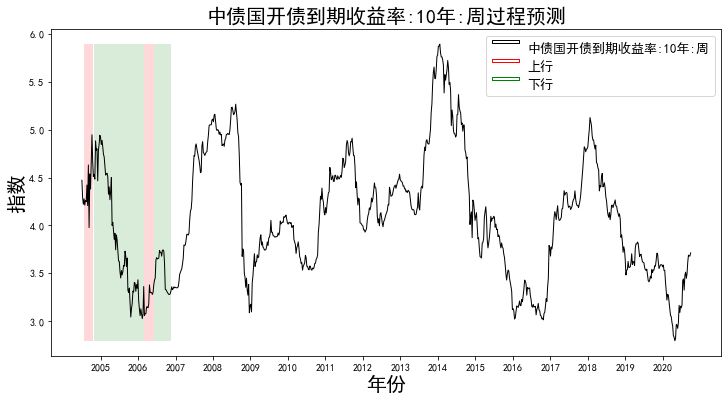

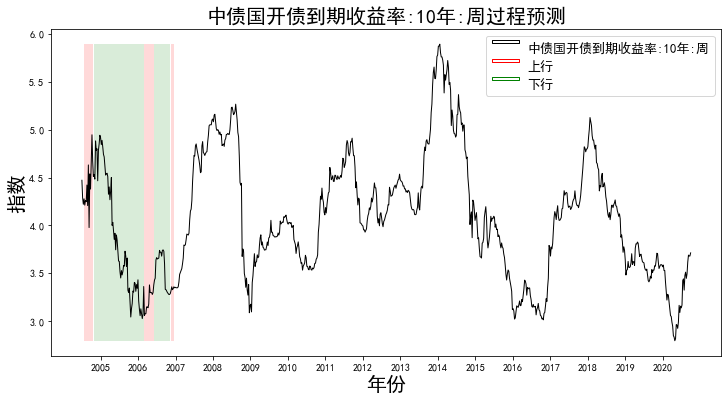

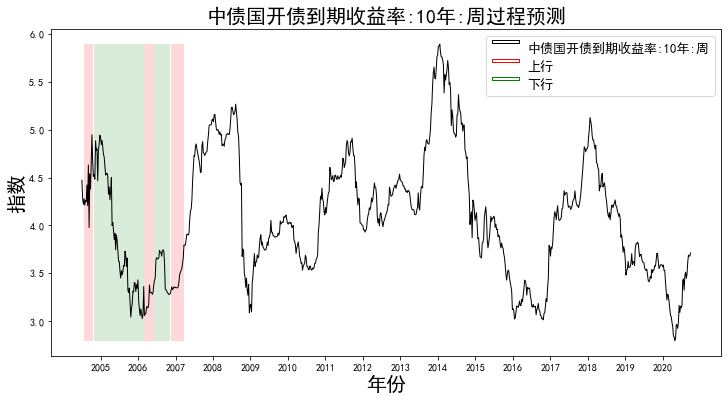

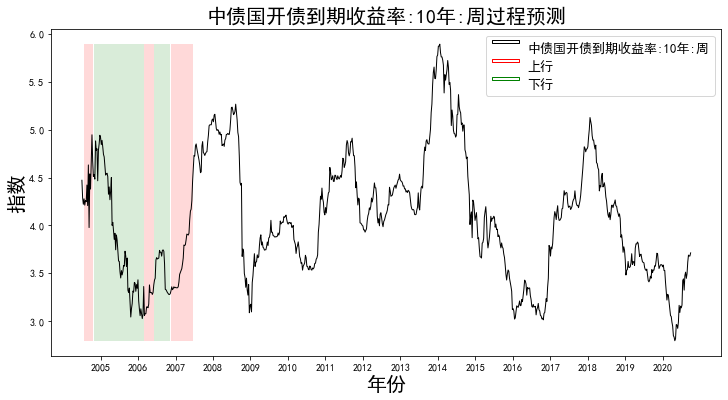

In [27]:
for i in range(10):
    supa_plot(d_w, und_pro(data[2], w_fast, w_slow)[i], 2, '过程')

# 1周趋势预测

In [28]:
prd_l = 4

## 移动平均（参照）

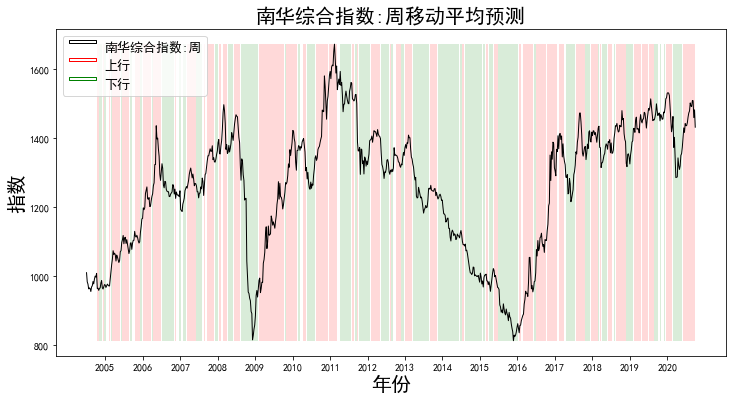

南华综合指数:周 移动平均 准确率 73.0 %
南华综合指数:周 移动平均 相对复杂度 6.61
南华综合指数:周 移动平均 单位时间收益率 1.12


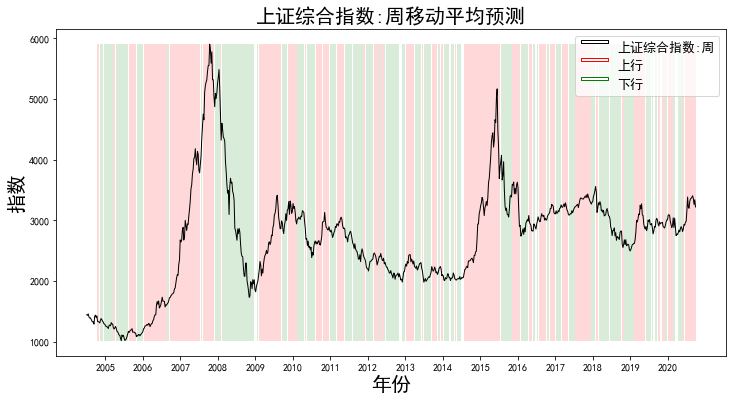

上证综合指数:周 移动平均 准确率 73.0 %
上证综合指数:周 移动平均 相对复杂度 6.58
上证综合指数:周 移动平均 单位时间收益率 2.92


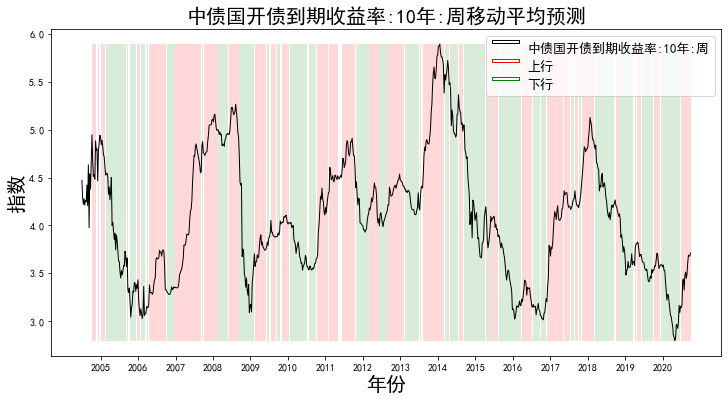

中债国开债到期收益率:10年:周 移动平均 准确率 73.0 %
中债国开债到期收益率:10年:周 移动平均 相对复杂度 4.42
中债国开债到期收益率:10年:周 移动平均 单位时间收益率 1.89


In [29]:
m_name = '移动平均'
for ii in range(len(data)):
    data_ma = ma(data[ii],l)
    ud_ma = comp(data[ii][l-1:],data_ma)
    
    supa_plot(d_w, ud_ma, ii, m_name)
    
    c += 1
    
    exec('a' + str(c) + '= 100*acc(ud_ma[:len(ud'+str(ii)+'[l-1:ud'+str(ii)+'.index(0)])],ud'+str(ii)+'[l-1:ud'+str(ii)+'.index(0)])')
    exec('c' + str(c) + '= round(cpx(ud_ma)*100/bc'+str(ii)+',2)')
    exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(ud_ma):],ud_ma)*100,2)')
    
    print(list(d_w)[ii], m_name,'准确率', eval('a'+str(c)),'%')
    print(list(d_w)[ii], m_name,'相对复杂度', eval('c'+str(c)))
    print(list(d_w)[ii], m_name,'单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

## 逻辑回归

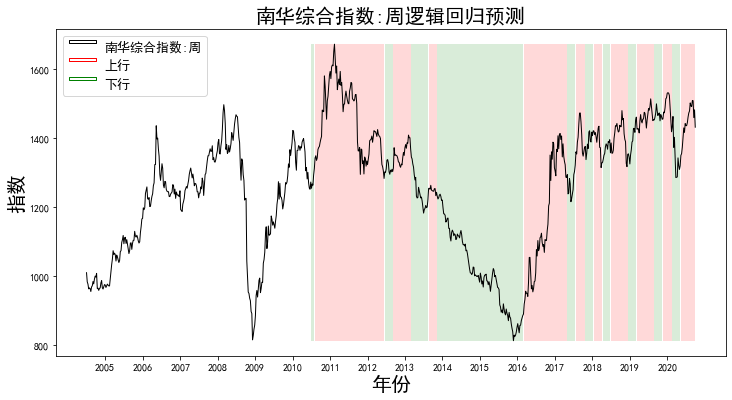

南华综合指数:周 准确率 69.0 %
南华综合指数:周 相对复杂度 1.65
南华综合指数:周 逻辑回归 单位时间收益率 1.59


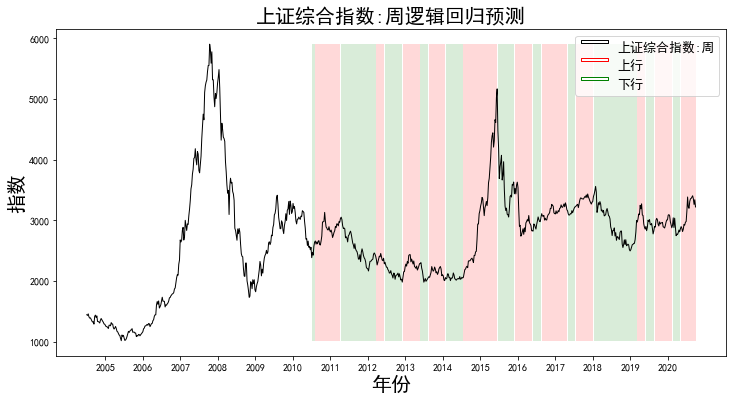

上证综合指数:周 准确率 72.0 %
上证综合指数:周 相对复杂度 2.16
上证综合指数:周 逻辑回归 单位时间收益率 2.91


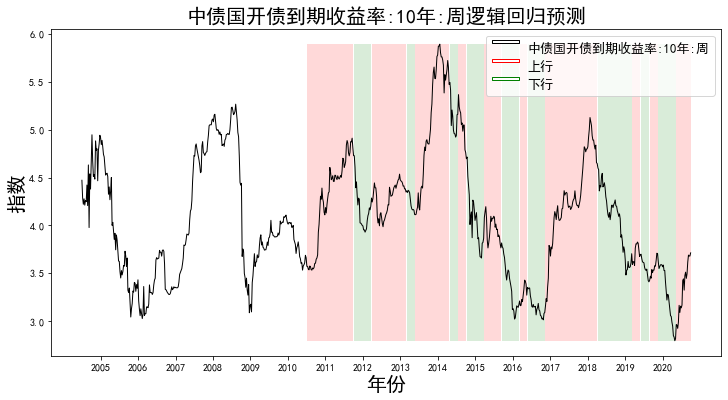

中债国开债到期收益率:10年:周 准确率 81.0 %
中债国开债到期收益率:10年:周 相对复杂度 1.57
中债国开债到期收益率:10年:周 逻辑回归 单位时间收益率 3.55


In [30]:
m_name = '逻辑回归'
logr = LogisticRegression()
for ii in range(len(data)):
    data_bond = [i[ii*L:(ii+1)*L] for i in df]
    logr_prd = []
    for i in range(start+prd_l,len(date)):
        cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
        l_ud = len(cur_ud)
        logr.fit(data_bond[:l_ud-prd_l], cur_ud[prd_l:])
        logr_res = logr.predict( [data_bond[i-l+1]] )[0]
        logr_prd.append(logr_res)
        
    _res = []
    
    logr_prd = logr_prd[::-1]
    
    for i in range(0, len(logr_prd), step):
        if i+step >= (len(logr_prd) - 1):
            _res += [-(-1) ** (sum(logr_prd[i:i+step]) >= 0)]*(len(logr_prd)-1-i)
            break
        else:
            _res += [-(-1) ** (sum(logr_prd[i:i+step]) >= 0)]*step
    
    _res = _res[::-1]
    
    supa_plot(d_w, _res, ii, m_name)
    
    c += 1
    
    temp_l = len(_res[:-w_slow])
    
    exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
    exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
    exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')
    
    print(list(d_w)[ii],'准确率', eval('a'+str(c)),'%')
    print(list(d_w)[ii],'相对复杂度', eval('c'+str(c)))
    print(list(d_w)[ii], m_name,'单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

## 决策树

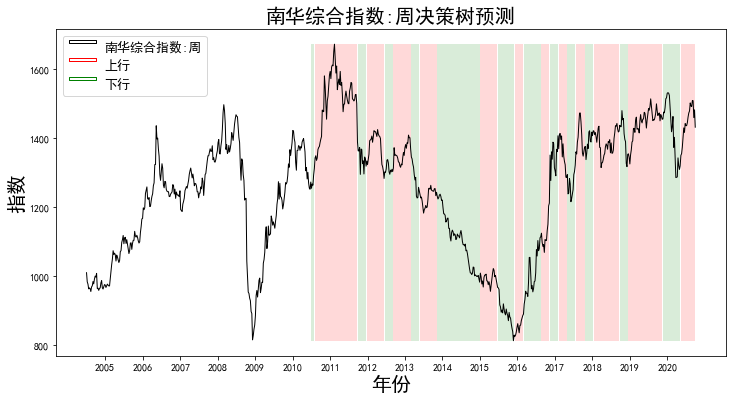

南华综合指数:周 准确率 65.0 %
南华综合指数:周 相对复杂度 1.98
南华综合指数:周 决策树 单位时间收益率 1.28


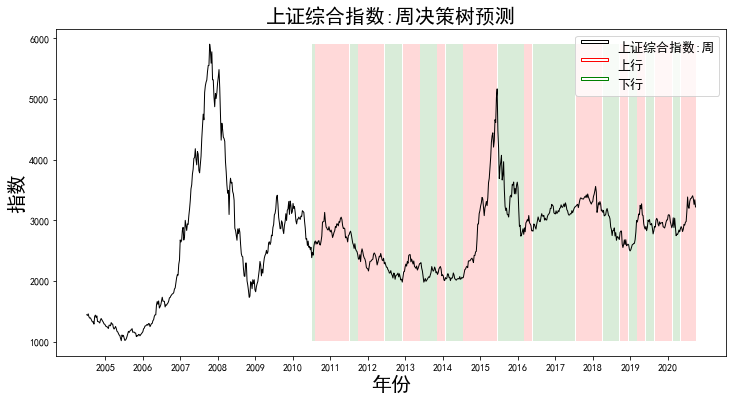

上证综合指数:周 准确率 61.0 %
上证综合指数:周 相对复杂度 2.16
上证综合指数:周 决策树 单位时间收益率 2.62


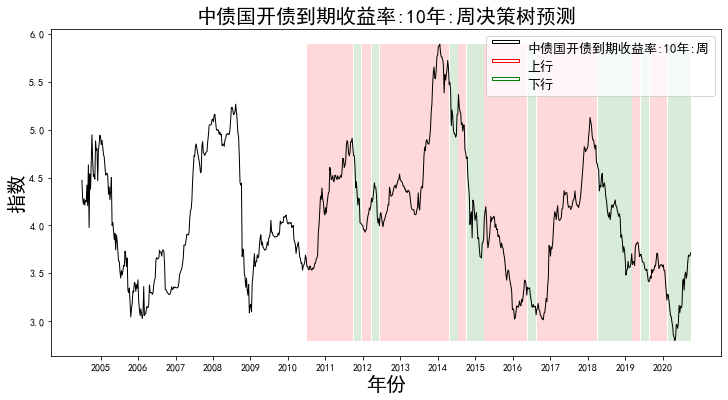

中债国开债到期收益率:10年:周 准确率 68.0 %
中债国开债到期收益率:10年:周 相对复杂度 1.32
中债国开债到期收益率:10年:周 决策树 单位时间收益率 2.34


In [31]:
m_name = '决策树'
tr = DecisionTreeClassifier()
for ii in range(len(data)):
    data_bond = [i[ii*L:(ii+1)*L] for i in df]
    tr_prd = []
    for i in range(start+prd_l,len(date)):
        cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
        l_ud = len(cur_ud) - prd_l        
        tr.fit(  data_bond[:l_ud] ,  cur_ud[prd_l:])
        tr_res = -(-1) ** int(tr.predict(  [data_bond[i-l+1]]  )  >= 0)
        tr_prd.append(tr_res)

    _res = []
    tr_prd = tr_prd[::-1]
    
    for i in range(0, len(tr_prd), step):
        if i+step >= (len(tr_prd) - 1):
            _res += [-(-1) ** (sum(tr_prd[i:i+step]) >= 0)]*(len(tr_prd)-1-i)
            break
        else:
            _res += [-(-1) ** (sum(tr_prd[i:i+step]) >= 0)]*step
    
    _res = _res[::-1]
    
    supa_plot(d_w, _res, ii, m_name)
    
    c += 1
    
    temp_l = len(_res[:-w_slow])
    
    exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
    exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
    exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')
    
    print(list(d_w)[ii],'准确率', eval('a'+str(c)),'%')
    print(list(d_w)[ii],'相对复杂度', eval('c'+str(c)))
    print(list(d_w)[ii], m_name,'单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

## 随机森林

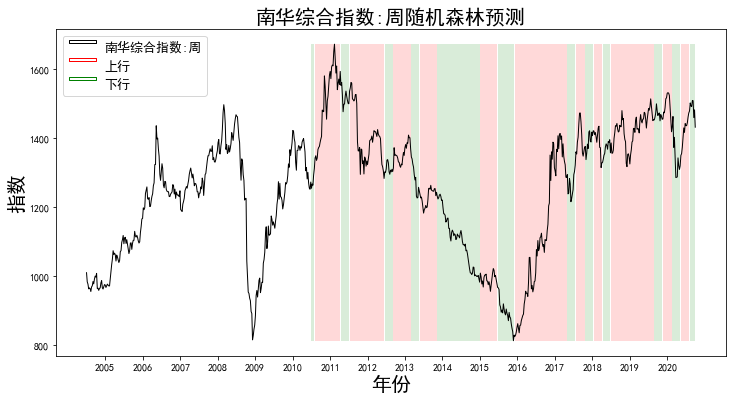

南华综合指数:周 准确率 68.0 %
南华综合指数:周 相对复杂度 1.9
南华综合指数:周 随机森林 单位时间收益率 1.89


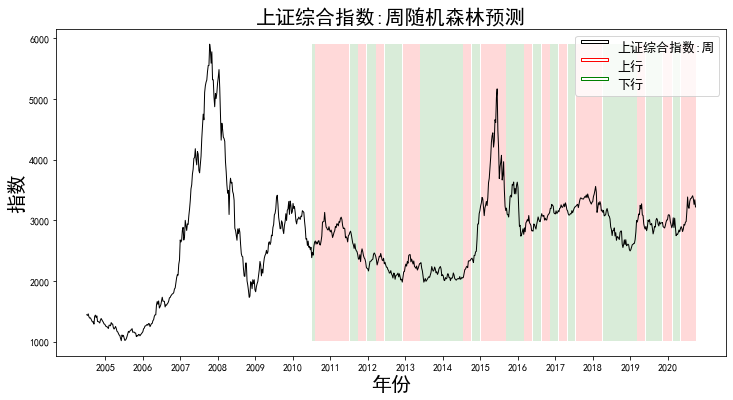

上证综合指数:周 准确率 72.0 %
上证综合指数:周 相对复杂度 2.55
上证综合指数:周 随机森林 单位时间收益率 1.83


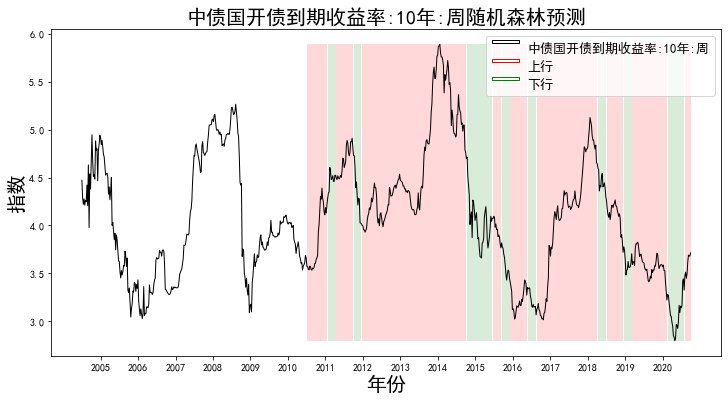

中债国开债到期收益率:10年:周 准确率 57.99999999999999 %
中债国开债到期收益率:10年:周 相对复杂度 1.41
中债国开债到期收益率:10年:周 随机森林 单位时间收益率 1.54


In [32]:
m_name = '随机森林'
rf = RandomForestRegressor(n_estimators = 5)
for ii in range(len(data)):
    data_bond = [i[ii*L:(ii+1)*L] for i in df]
    rf_prd = []
    for i in range(start+prd_l,len(date)):
        
            cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
            l_ud = len(cur_ud) -prd_l
            rf.fit(  data_bond[:l_ud] ,  cur_ud[prd_l:])
            rf_res = -(-1) ** int( rf.predict(  [data_bond[i-l+1]]  ) >= 0)
            rf_prd += [rf_res]
    
    _res = []
    rf_prd = rf_prd[::-1]
    
    for i in range(0, len(rf_prd), step):
        if i+step >= (len(rf_prd) - 1):
            _res += [-(-1) ** (sum(rf_prd[i:i+step]) >= 0)]*(len(rf_prd)-1-i)
            break
        else:
            _res += [-(-1) ** (sum(rf_prd[i:i+step]) >= 0)]*step
    
    _res = _res[::-1]
    
    supa_plot(d_w, _res, ii, m_name)
    
    c += 1
    
    temp_l = len(_res[:-w_slow])
    
    exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
    exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
    exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')
    
    print(list(d_w)[ii],'准确率', eval('a'+str(c)),'%')
    print(list(d_w)[ii],'相对复杂度', eval('c'+str(c)))
    print(list(d_w)[ii], m_name,'单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

## 支持向量机

### 线性

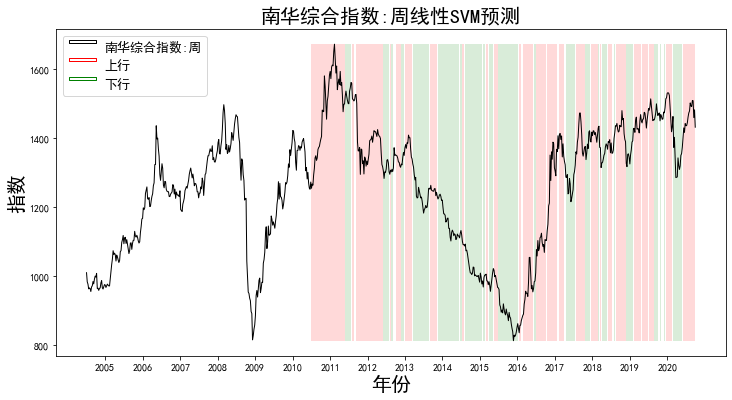

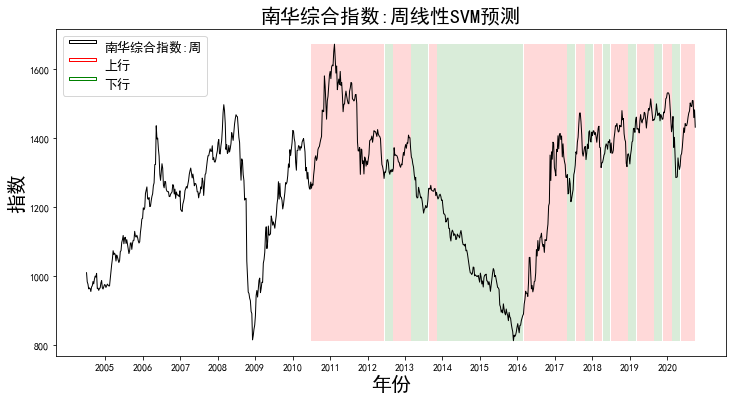

南华综合指数:周 准确率 70.0 %
南华综合指数:周 相对复杂度 1.57
南华综合指数:周 线性SVM 单位时间收益率 1.61


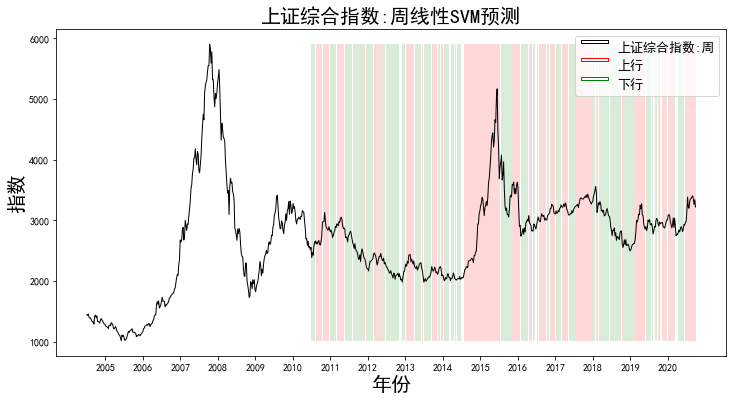

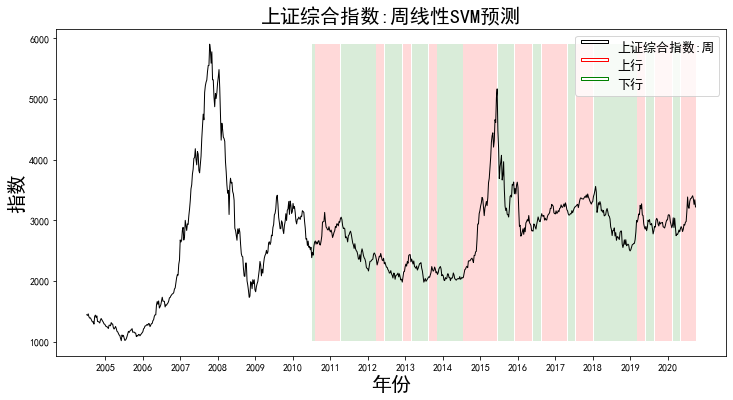

上证综合指数:周 准确率 76.0 %
上证综合指数:周 相对复杂度 2.16
上证综合指数:周 线性SVM 单位时间收益率 3.33


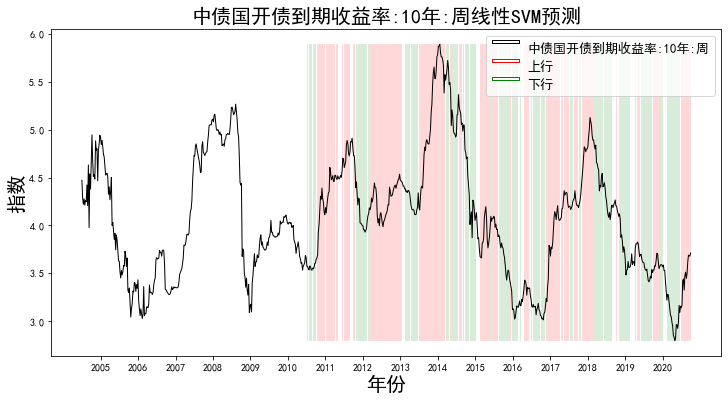

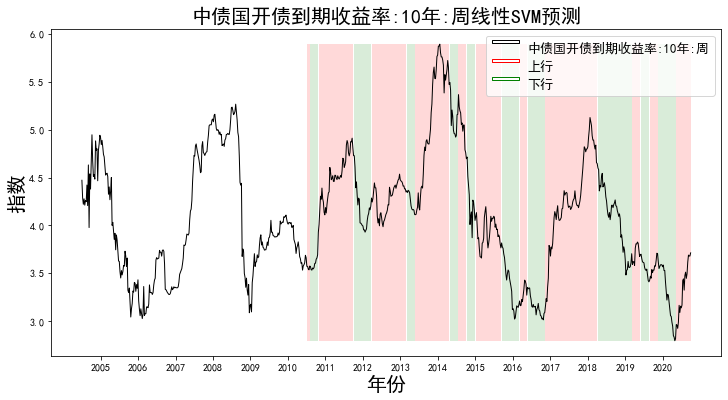

中债国开债到期收益率:10年:周 准确率 76.0 %
中债国开债到期收益率:10年:周 相对复杂度 1.74
中债国开债到期收益率:10年:周 线性SVM 单位时间收益率 3.23


In [33]:
_svm1 = svm.SVC(kernel='linear')
m_name = '线性SVM'

for ii in range(len(data)):
    svm_prd = []
    data_bond = [i[ii*L:(ii+1)*L] for i in df]
    for i in range(start+prd_l,len(date)):
        cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
        l_ud = len(cur_ud) - prd_l
        _svm1.fit(  data_bond[:l_ud],  cur_ud[prd_l:] )
        svm_res =  _svm1.predict(  [data_bond[i-l+1]]  )[0]
        svm_prd.append(svm_res)
        
    _res = []
    
    supa_plot(d_w, svm_prd, ii, m_name)
    svm_prd = svm_prd[::-1]
    
    for i in range(0, len(svm_prd), step):
        if i+step >= (len(svm_prd) - 1):
            _res += [-(-1) ** (sum(svm_prd[i:i+step]) >= 0)]*(len(svm_prd)-1-i)
            break
        else:
            _res += [-(-1) ** (sum(svm_prd[i:i+step]) >= 0)]*step
    
    _res = _res[::-1]
    
    supa_plot(d_w, _res, ii, m_name)

    temp_l = len(_res[:-w_slow])
    
    c += 1
    
    exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
    exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
    exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')
    
    print(list(d_w)[ii],'准确率', eval('a'+str(c)),'%')
    print(list(d_w)[ii],'相对复杂度', eval('c'+str(c)))
    print(list(d_w)[ii], m_name,'单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

### 高斯

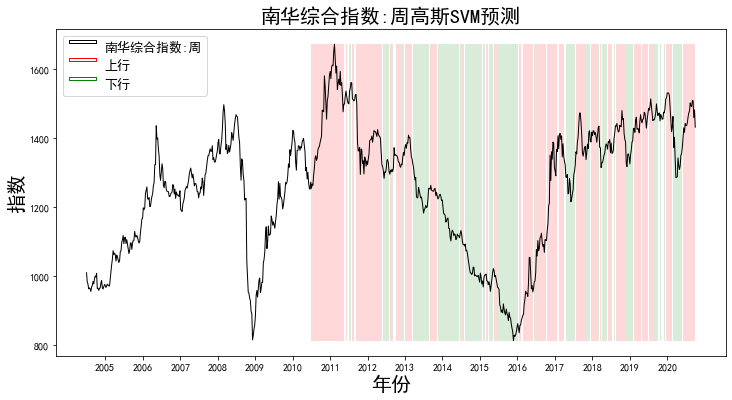

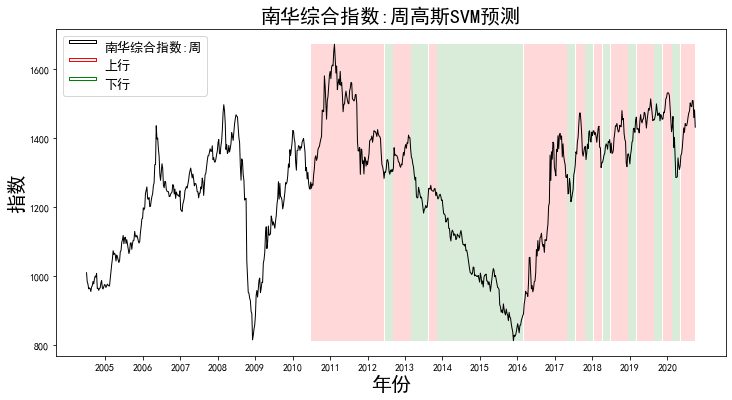

南华综合指数:周 准确率 70.0 %
南华综合指数:周 相对复杂度 1.57
南华综合指数:周 高斯SVM 单位时间收益率 1.61


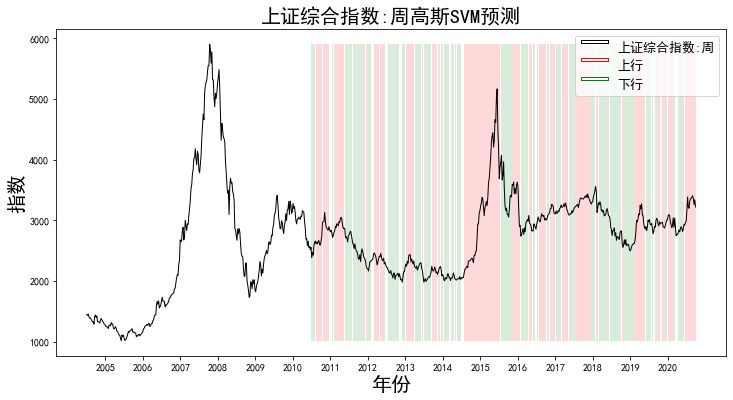

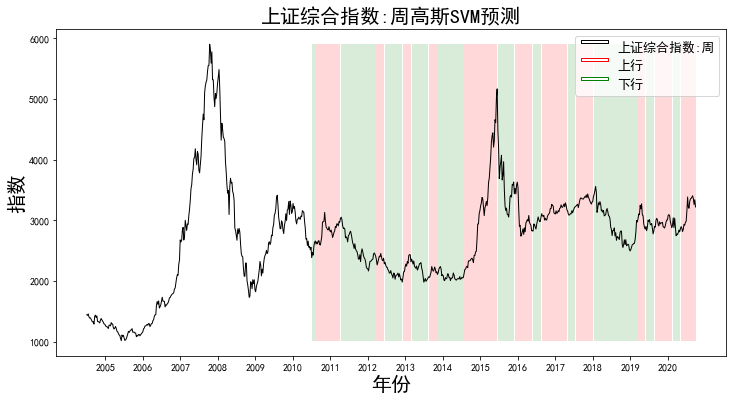

上证综合指数:周 准确率 76.0 %
上证综合指数:周 相对复杂度 2.16
上证综合指数:周 高斯SVM 单位时间收益率 3.33


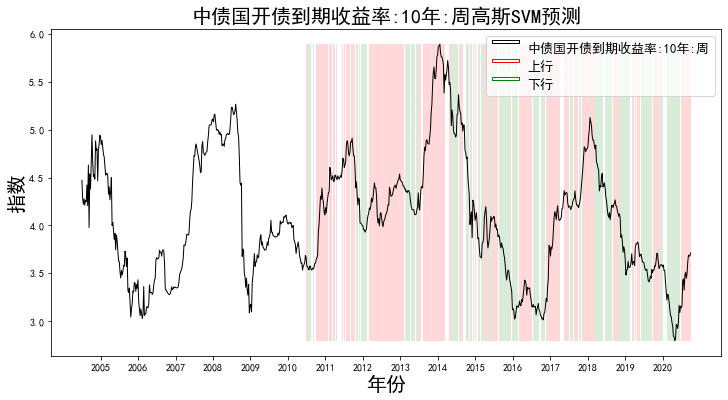

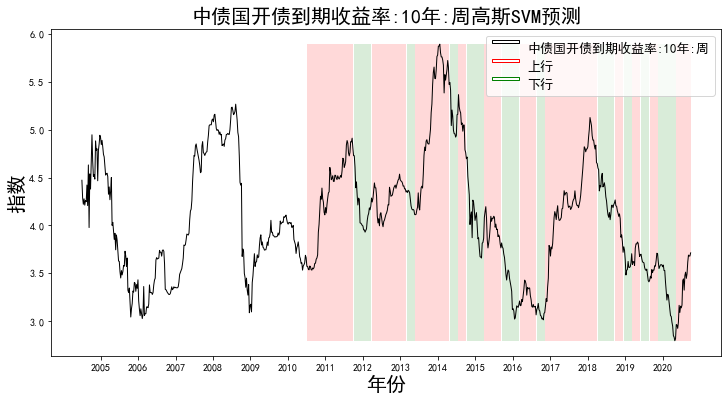

中债国开债到期收益率:10年:周 准确率 76.0 %
中债国开债到期收益率:10年:周 相对复杂度 1.74
中债国开债到期收益率:10年:周 高斯SVM 单位时间收益率 3.22


In [34]:
_svm3 = svm.SVC(C=1,kernel='rbf')
m_name = '高斯SVM'

for ii in range(len(data)):
    svm_prd = []
    data_bond = [i[ii*L:(ii+1)*L] for i in df]
    for i in range(start+prd_l,len(date)):
        cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
        l_ud = len(cur_ud) - prd_l
        _svm3.fit(  data_bond[:l_ud],  cur_ud[prd_l:] )
        svm_res =  _svm3.predict(  [data_bond[i-l+1]]  )[0]
        svm_prd.append(svm_res)
        
    _res = []
    
    supa_plot(d_w, svm_prd, ii, m_name)
    svm_prd = svm_prd[::-1]
    
    for i in range(0, len(svm_prd), step):
        if i+step >= (len(svm_prd) - 1):
            _res += [-(-1) ** (sum(svm_prd[i:i+step]) >= 0)]*(len(svm_prd)-1-i)
            break
        else:
            _res += [-(-1) ** (sum(svm_prd[i:i+step]) >= 0)]*step
    
    _res = _res[::-1]
    
    supa_plot(d_w, _res, ii, m_name)

    temp_l = len(_res[:-w_slow])
    
    c += 1
    
    exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
    exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
    exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')
    
    print(list(d_w)[ii],'准确率', eval('a'+str(c)),'%')
    print(list(d_w)[ii],'相对复杂度', eval('c'+str(c)))
    print(list(d_w)[ii], m_name,'单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

## XGBoost

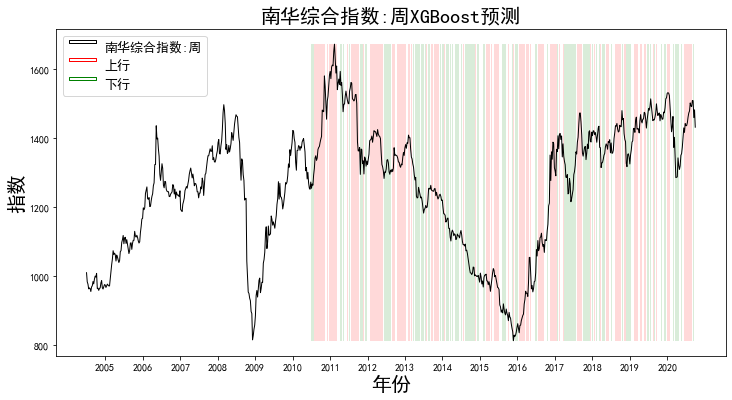

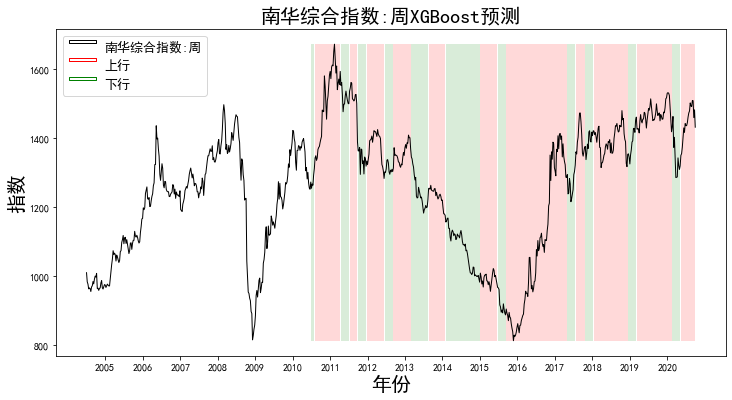

南华综合指数:周 准确率 71.0 %
南华综合指数:周 相对复杂度 1.82
南华综合指数:周 XGBoost 单位时间收益率 1.77


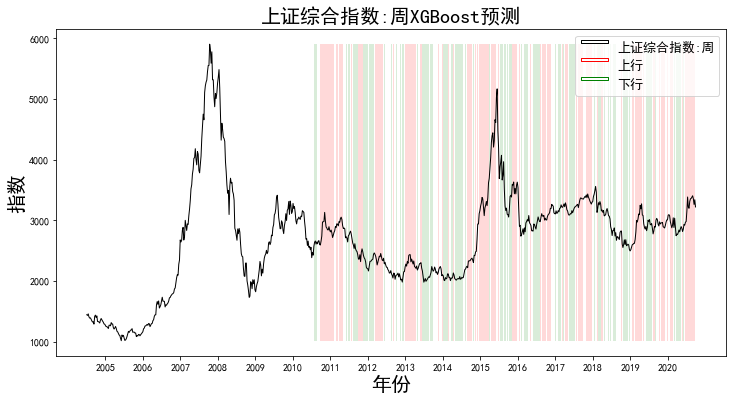

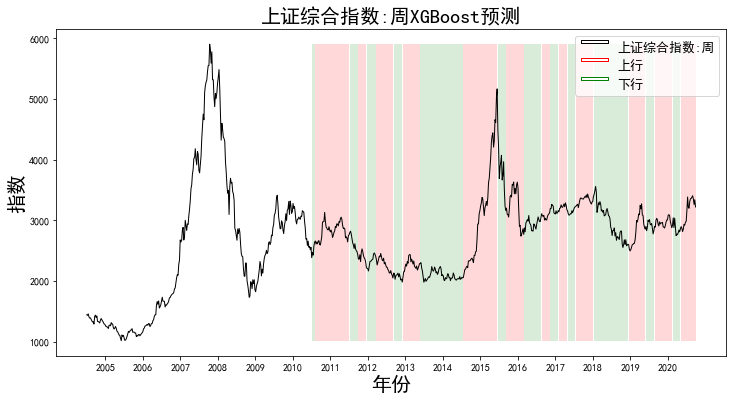

上证综合指数:周 准确率 65.0 %
上证综合指数:周 相对复杂度 2.36
上证综合指数:周 XGBoost 单位时间收益率 2.27


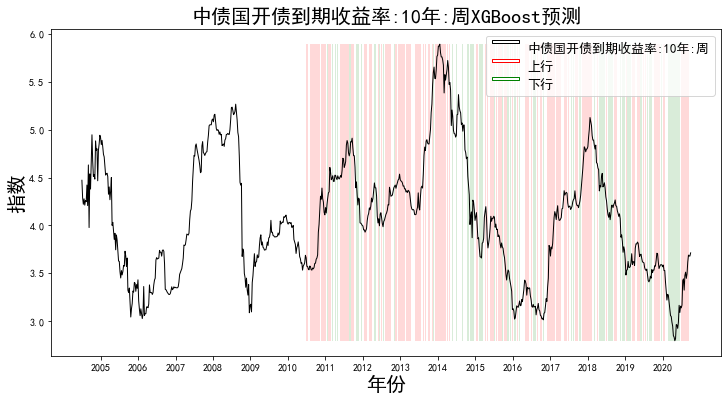

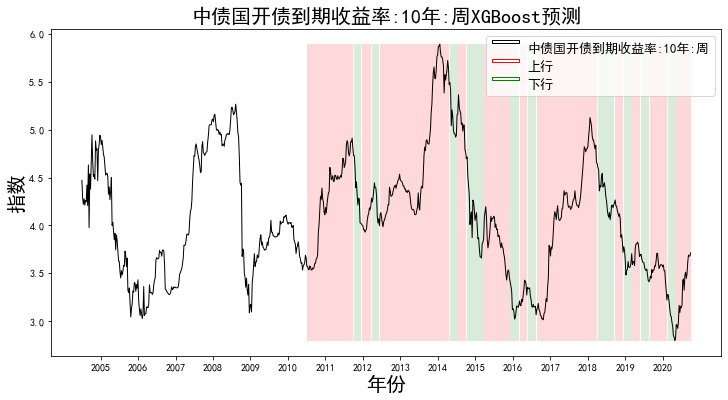

中债国开债到期收益率:10年:周 准确率 68.0 %
中债国开债到期收益率:10年:周 相对复杂度 1.74
中债国开债到期收益率:10年:周 XGBoost 单位时间收益率 3.06


In [35]:
param = {'learning_rate':0.1,'objective':'binary:logistic' }
num_round = 100
m_name = 'XGBoost'

for ii in range(len(data)):
    xg_prd = []
    data_bond = [i[ii*L:(ii+1)*L] for i in df]
    
    for i in range(start+prd_l,len(date)):
        cur_ud = und(data[ii][:i+1], w_fast, w_slow)[l-1:-w_slow]
        l_ud = len(cur_ud) - prd_l
        dtrain = xgb.DMatrix(np.array(data_bond[:l_ud]), label = np.array(cur_ud[prd_l:])==1)
        dtest = xgb.DMatrix(np.array([data_bond[i-l+1]]))
        bst = xgb.train(param, dtrain, num_round)
        xg_prd.append(-(-1) ** (bst.predict(dtest)[0]>=.5))
        
    _res = []
    
    supa_plot(d_w, xg_prd, ii, m_name)
    xg_prd = xg_prd[::-1]
    
    for i in range(0, len(xg_prd), step):
        if i+step >= (len(xg_prd) - 1):
            _res += [-(-1) ** (sum(xg_prd[i:i+step]) >= 0)]*(len(xg_prd)-1-i)
            break
        else:
            _res += [-(-1) ** (sum(xg_prd[i:i+step]) >= 0)]*step
    
    _res = _res[::-1]
    
    supa_plot(d_w, _res, ii, m_name)

    temp_l = len(_res[:-w_slow])
    
    c += 1
    
    exec('a' + str(c) + '= 100*acc(_res[:-w_slow],ud'+str(ii)+'[:-w_slow][-temp_l:])')
    exec('c' + str(c) + '= round(100*cpx(_res)/bc'+str(ii)+',2)')
    exec('p' + str(c) + '= round(profit(data['+str(ii)+'][-len(_res):], _res)*100,2)')
    
    print(list(d_w)[ii],'准确率', eval('a'+str(c)),'%')
    print(list(d_w)[ii],'相对复杂度', eval('c'+str(c)))
    print(list(d_w)[ii], m_name,'单位时间收益率', eval('p'+str(c)))
    
r_name.append(m_name)

# 总结

In [36]:
final_result = [[],[],[]]
rc = 0
for i in range(1,c+1):
    final_result[rc].append([eval('a'+str(i)), eval('c'+str(i)), eval('p'+str(i))])
    if rc != 2:
        rc += 1
    else:
        rc = 0

with pd.ExcelWriter('sbc.xlsx') as writer:
    for i in range(len(list(d_w))):
        name = list(d_w)[i]
        dff = pd.DataFrame(final_result[i])     
        dff.columns = ['准确度（%）', '相对复杂度', '单位时间收益率（%）']
        dff.index = r_name
        dff.to_excel(writer, sheet_name =  list(d_w)[i][:list(d_w)[i].index(':')] )

writer.save()
writer.close()

FileCreateError: [Errno 13] Permission denied: 'sbc.xlsx'